In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle


seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float)
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float)
        
    def forward(self, x):
        return self.linear(x)


/home/b-sgolechha/miniconda3/envs/kihopark/lib/python3.10/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
class BioMLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth
                 
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))
            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)
        
        
        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))
        
        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding

    def forward(self, x):
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)
        
        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]
        
        return x
    
    def get_linear_layers(self):
        return self.linears
    
    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc
    
    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():  
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))
            
    def swap_bias(self, biases, j, k):
        with torch.no_grad():  
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp
    
    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron. 
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped. 
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index
    
    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)
            
    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)
            
    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)
            
    def plot(self):
        fig, ax = plt.subplots(figsize=(6,6))
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        linears = self.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight.clone()
            p_shp = p.shape
            
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=1*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=0.5*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                    
        ax.axis('off')
        

torch.Size([3481])
tensor([-1.9453e-04, -1.7303e-04, -8.5102e-05, -2.1111e-04,  4.5192e-05,
         1.9831e-05,  4.3272e-05, -6.6335e-05, -3.8710e-05, -6.1369e-05,
        -5.7713e-05,  2.0011e-04, -7.1323e-05, -1.0651e-04, -1.6087e-04,
         3.0373e-05, -9.5117e-05,  9.0841e-05, -1.1940e-04,  2.2502e-06,
         1.1391e-04, -8.4958e-05,  1.4455e-05, -1.7290e-04,  2.1348e-05,
        -1.1129e-04,  1.2781e-05, -1.0865e-04,  6.4381e-05, -1.1912e-04,
         7.4266e-05,  2.6716e-05, -1.0532e-05, -1.9348e-05,  1.6689e-04,
        -1.7730e-04, -1.2162e-05,  6.0073e-05, -1.8789e-05, -4.6989e-06,
        -1.8947e-04,  1.5287e-04,  4.1356e-05,  2.2711e-04, -1.9010e-04,
        -1.4304e-04, -1.3808e-04, -1.5297e-04,  1.1221e-04,  8.0741e-06])
step = 0 | total loss: 4.16e+00 | train loss: 4.08e+00 | test loss 4.09e+00 | cc: 7.36e-01 | train acc: 1.65e-02 | test acc: 1.00e-02 


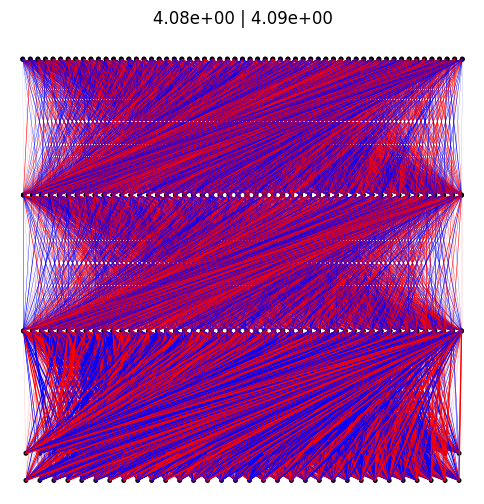

tensor([ 1.7277e-04,  2.1679e-03, -1.1874e-03,  5.7619e-03, -2.8847e-04,
         1.0779e-04,  2.7900e-03, -7.3986e-04,  6.2994e-05, -5.4019e-03,
        -5.4003e-04, -1.3313e-03,  2.2156e-03,  1.5279e-04, -2.5194e-03,
        -2.2508e-03, -4.0491e-03,  6.0499e-04, -1.9677e-04, -1.3355e-03,
        -1.5007e-03,  8.4968e-04, -2.0830e-04,  2.5226e-04, -4.0027e-05,
        -1.5559e-04,  3.9660e-04, -7.1330e-05, -1.3820e-04,  3.8050e-04,
        -6.3517e-04, -1.3037e-03, -6.0452e-06,  2.0433e-04,  2.1370e-04,
        -1.8549e-03, -2.3344e-03,  3.1427e-04, -5.8363e-03,  8.0397e-04,
         1.4539e-04,  9.9837e-05,  5.1200e-04,  4.8232e-04, -8.9060e-05,
         1.5779e-03, -2.7116e-04, -1.7369e-04,  1.1397e-05,  2.6944e-04])
step = 200 | total loss: 2.32e+00 | train loss: 2.21e+00 | test loss 5.39e+00 | cc: 1.08e+00 | train acc: 3.97e-01 | test acc: 1.15e-02 


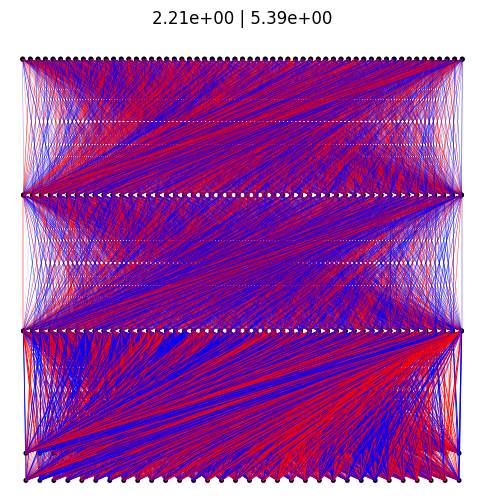

tensor([-1.1805e-04, -1.2220e-04, -7.0218e-05, -1.2963e-04, -7.2651e-05,
         3.5058e-05, -1.4598e-04, -2.4928e-04,  7.3541e-05, -7.5814e-04,
        -3.8290e-05,  3.1030e-04,  6.4068e-05, -4.4696e-05, -8.3867e-04,
         1.1455e-04,  8.2083e-04,  1.2511e-04, -1.4853e-04,  1.5810e-04,
        -2.5977e-04, -1.2770e-04,  3.7799e-05,  4.5079e-05,  8.6106e-05,
        -2.5628e-05, -2.5424e-04, -6.8163e-04,  2.2606e-05, -2.1151e-04,
        -9.5811e-05, -1.3363e-04,  4.3549e-07,  2.7956e-04,  1.0504e-04,
         4.0500e-04, -7.9593e-05, -5.5903e-04, -6.2183e-04, -8.8735e-05,
         4.3193e-05,  4.3062e-05,  2.5942e-05, -1.3661e-04, -7.6807e-05,
         2.6098e-05, -2.7134e-05, -4.4456e-05, -5.3764e-05, -1.2808e-04])
step = 400 | total loss: 1.73e-01 | train loss: 3.71e-02 | test loss 2.60e+00 | cc: 1.36e+00 | train acc: 1.00e+00 | test acc: 4.12e-01 


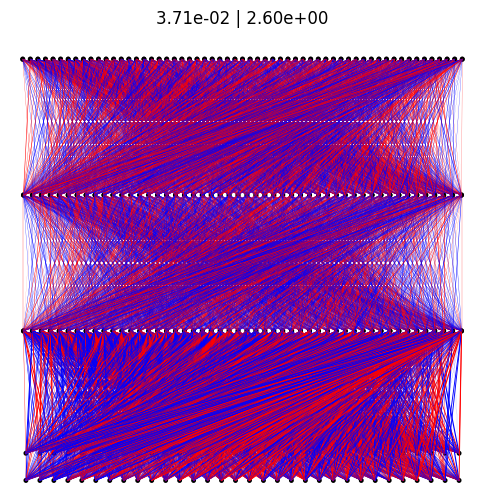

tensor([ 3.7852e-05, -1.4215e-05, -3.3063e-05,  7.6518e-06, -7.1375e-05,
        -3.4182e-05,  6.7553e-05,  1.8736e-05,  1.2939e-05,  5.3660e-06,
         2.5085e-05, -1.0590e-06, -9.3665e-06, -4.0870e-06,  1.0599e-05,
        -2.3689e-05,  1.3136e-05, -2.1514e-05,  8.1428e-05,  3.5082e-05,
         4.8128e-06,  6.6946e-06,  1.2102e-06, -7.9369e-05, -6.5879e-05,
         6.8730e-05,  3.8512e-05,  7.3799e-05, -7.4449e-05,  8.2278e-06,
        -6.4127e-05,  6.5116e-05, -4.2592e-05, -3.3757e-05,  3.2660e-05,
         7.6400e-05, -7.9704e-05,  6.3847e-05,  5.1576e-06,  7.8614e-05,
        -6.1584e-05,  1.0445e-04, -4.6110e-05,  1.1422e-04, -6.2052e-05,
        -8.6710e-05, -6.1332e-05,  3.1024e-05,  5.5066e-05,  2.7791e-05])
step = 600 | total loss: 1.41e-01 | train loss: 6.06e-03 | test loss 1.76e+00 | cc: 1.35e+00 | train acc: 1.00e+00 | test acc: 5.77e-01 


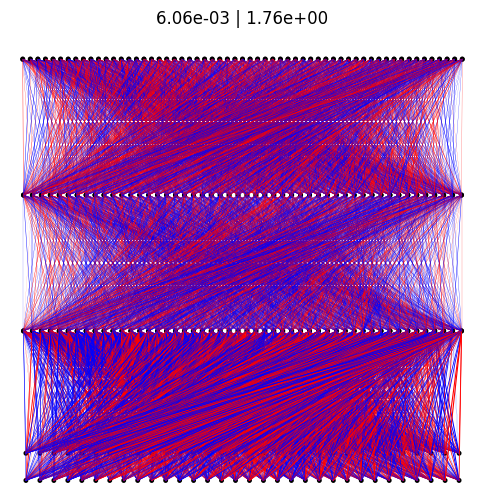

tensor([ 1.9553e-05,  1.2044e-05,  4.5930e-06, -1.6482e-06, -6.3549e-05,
        -3.3115e-05,  2.2744e-05,  1.5379e-05, -1.4586e-05,  3.5138e-05,
         1.4223e-05, -8.4818e-06,  5.3630e-06, -2.6850e-06,  1.1226e-05,
        -2.5779e-05, -4.8619e-05, -2.5098e-05,  3.7981e-05, -7.4155e-05,
         3.7247e-05, -2.9837e-06,  1.0909e-05, -5.3723e-05, -1.8423e-05,
         2.1110e-05,  6.7444e-05,  3.8086e-05, -3.1533e-05,  6.5381e-07,
        -9.1457e-05,  6.8167e-05, -8.6043e-05, -6.0023e-05, -6.9164e-05,
         4.9365e-05, -1.0233e-04,  5.8995e-05, -3.9579e-05,  8.4191e-05,
        -6.7375e-05,  8.3609e-05, -6.5971e-05,  8.6118e-05, -9.4450e-05,
         8.1386e-05, -6.1707e-05,  2.1276e-05, -1.3723e-04,  2.9145e-05])
step = 800 | total loss: 1.34e-01 | train loss: 3.35e-03 | test loss 1.26e+00 | cc: 1.30e+00 | train acc: 1.00e+00 | test acc: 6.70e-01 


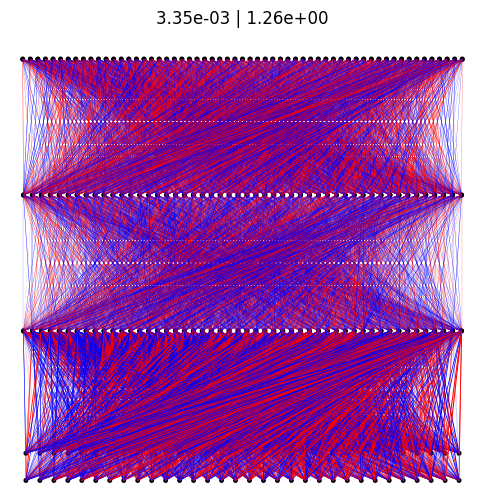

tensor([ 1.6489e-05,  1.4938e-05,  1.0595e-05, -1.0893e-06, -6.2557e-05,
        -3.4709e-05, -5.6971e-06, -4.0928e-05, -4.8856e-06,  3.1545e-05,
         8.9904e-06,  2.6320e-05, -3.9622e-06, -3.1610e-05, -5.0550e-06,
         9.4078e-06, -7.2397e-05,  2.9918e-05, -2.8561e-05, -7.8592e-05,
         3.9107e-05, -1.0751e-05, -4.9153e-05,  1.4966e-05, -3.3982e-05,
         4.2753e-05,  3.1503e-05,  8.1562e-06, -1.7123e-05,  5.4067e-05,
        -7.7028e-05, -7.6401e-05, -6.9281e-05,  7.3803e-05,  8.1914e-05,
         7.3727e-05, -1.0248e-04,  6.7781e-05, -4.0281e-05,  7.3404e-05,
         1.0065e-04,  8.9074e-05, -7.1160e-05,  8.2396e-05, -6.7498e-05,
         9.0952e-05, -7.1522e-05,  1.9641e-05,  5.8646e-05,  3.8692e-05])
step = 1000 | total loss: 1.28e-01 | train loss: 2.64e-03 | test loss 8.70e-01 | cc: 1.25e+00 | train acc: 1.00e+00 | test acc: 7.76e-01 


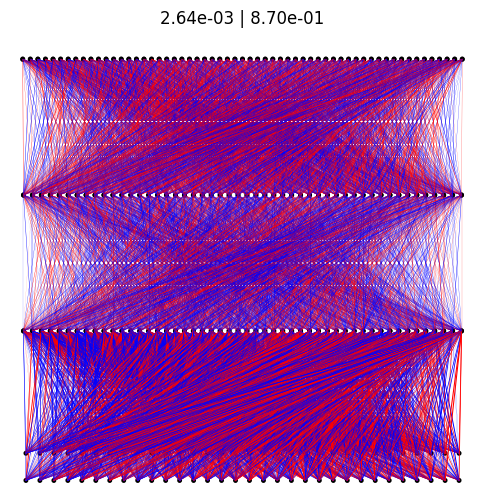

KeyboardInterrupt: 

In [3]:
import math

seed = 4
np.random.seed(seed)
torch.manual_seed(seed)

### create model ###
p = 59
d = 32
in_dim = 2*d
out_dim = p

shp = [in_dim, 50, 50, out_dim]
model = BioMLP(shp=shp, token_embedding=True, embedding_size=(p, d))

### create dataset ###

x = np.arange(p)
y = np.arange(p)
XX, YY = np.meshgrid(x, y)
data_id = np.transpose([XX.reshape(-1,), YY.reshape(-1,)])
labels = (data_id[:,0] + data_id[:,1]) % p
labels = torch.tensor(labels, dtype=torch.long)
print(labels.shape)
fraction = 0.8
train_num = int(p**2*fraction)
test_num = p**2 - train_num

train_id = np.random.choice(p**2,train_num,replace=False)
test_id = np.array(list(set(np.arange(p**2)) - set(train_id)))

def get_data(id_):
    global labels
    inputs = torch.cat([model.embedding[data_id[id_][:,0]], model.embedding[data_id[id_][:,1]]], dim=1)
    return inputs, labels[id_]


### train ###
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0)
steps = 20000
log = 200
lamb = 0.1
swap_log = 200
# plot_log = 200
plot_log = 2000

for step in range(steps):
    
    if step == int(steps*1/4):
        lamb *= 10
        
    if step == int(steps*3/4):
        lamb *= 0.1
    
    
    CEL = nn.CrossEntropyLoss()
    
    optimizer.zero_grad()
    
    
    inputs_train, labels_train = get_data(train_id)
    pred  = model(inputs_train)
    loss = CEL(pred, labels_train)
    acc = torch.mean((torch.argmax(pred, dim=1) == labels_train).float())
    
    inputs_test, labels_test = get_data(test_id)
    pred_test  = model(inputs_test)
    loss_test = CEL(pred_test, labels_test)
    acc_test = torch.mean((torch.argmax(pred_test, dim=1) == labels_test).float())
    
    cc = model.get_cc(weight_factor=2.0, no_penalize_last=False)
    #cc = model.get_cc(weight_factor=2.0, no_penalize_last=True) # this gives 3+2 Tree.
    total_loss = loss + lamb*cc
    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print(model.linears[1].linear.weight.grad[0])
    
    
    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | cc: %.2e | train acc: %.2e | test acc: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), loss_test.detach().numpy(), cc.detach().numpy(), acc.detach().numpy(), acc_test.detach().numpy()))
    if (step+1) % swap_log == 0:
        model.relocate()
        
    if step % plot_log == 0:
        pass
        #print("plot!!!")
        model.plot()
        plt.title("%.2e | %.2e" % (loss.detach().numpy(), loss_test.detach().numpy()))
        plt.show()
        #plt.savefig("./video_figs/toy_swap/{0:05d}.png".format(step))


In [ ]:
model.plot()
d = 32
for i in range(d):
    plt.text(i/d+0.007, -0.02, i+1, fontsize=6)
    
plt.text(-0.15,-0.005, "input", fontsize=15)
plt.text(-0.1,0.095, "L1", fontsize=15)
plt.text(-0.1,0.195, "L2", fontsize=15)
plt.text(-0.17,0.295, "output", fontsize=15)
plt.title("Modular addition", y=1.05, fontsize=15)

plt.text(0.318,-0.025,"{",rotation=90,fontsize=15)
plt.text(0.327,-0.045,"A",fontsize=15)

plt.text(0.502,-0.025,"{",rotation=90,fontsize=15)
plt.text(0.52,-0.045,"B",fontsize=15)

plt.text(0.632,-0.025,"{",rotation=90,fontsize=23)
plt.text(0.655,-0.045,"C",fontsize=15)

plt.savefig('./fig/modadd_graph.png', bbox_inches="tight")

In [ ]:
from sklearn.decomposition import PCA

plt.figure(figsize=(5,17))

plt.subplot(3,1,1)
data = model.embedding[:,model.in_perm.long()[[10,11]]].detach().numpy()
pca = PCA(n_components=2)
data = pca.fit_transform(data)

j = 0; k = 1
for i in range(p):
    plt.scatter(data[i,j], data[i,k], color="blue",alpha=0.5)
    plt.text(data[i,j], data[i,k], i, fontsize=10)
    
#plt.xlim(-0.9,1.3)
#plt.ylim(-0.9,1.3)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.arrow(0,0,0.15,0.0,head_length=0.02,head_width=0.015, color="black")
plt.arrow(0,0,0.0,0.15,head_length=0.02,head_width=0.015, color="black")
plt.title("A", fontsize=45)


    
    
plt.subplot(3,1,2)
data = model.embedding[:,model.in_perm.long()[[16,17]]].detach().numpy()
pca = PCA(n_components=2)
data = pca.fit_transform(data)

j = 0; k = 1
for i in range(p):
    plt.scatter(data[i,j], data[i,k], color="blue",alpha=0.5)
    plt.text(data[i,j], data[i,k], i, fontsize=10)
    
#plt.xlim(-0.9,1.3)
#plt.ylim(-0.9,1.3)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.arrow(0,0,0.15,0.0,head_length=0.02,head_width=0.015, color="black")
plt.arrow(0,0,0.0,0.15,head_length=0.02,head_width=0.015, color="black")
plt.title("B", fontsize=45)


ax = plt.subplot(313, projection = '3d')

data = model.embedding[:,model.in_perm.long()[[20,21,22]]].detach().numpy()
pca = PCA(n_components=3)
data = pca.fit_transform(data)


for i in range(p):
    ax.scatter(data[i,0], data[i,1], data[i,2], color="blue", alpha=0.5)
    ax.text(data[i,0], data[i,1], data[i,2], i)
    
ax.view_init(-140, 40)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
lim = 0.4
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
ax.set_zlim(-lim,lim)
plt.axis('off') 

ax.quiver([0],[0],[0],[0.2],[0],[0], color="black")
ax.quiver([0],[0],[0],[0],[0.2],[0], color="black")
ax.quiver([0],[0],[0],[0],[0],[0.2], color="black")

plt.title("C", fontsize=45)
    

plt.savefig('./fig/modadd_rings.pdf', bbox_inches="tight")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(p):
    ax.scatter(data[i,0], data[i,1], data[i,2], color="blue")
    ax.text(data[i,0], data[i,1], data[i,2], i)
    
ax.view_init(-140, 20)

In [ ]:
# set some of embedding dimension to be zero (knockout experiments)


embedding_original = model.embedding.data.clone()

with torch.no_grad():
    model.embedding.data[:,model.in_perm.long()[[0,1,2,3,4,5,6,7,8,9,12,13,14,15,18,19,23,24,25,26,27,28,29,30,31]]] = 0.
    
inputs, labels = get_data(id_)
pred  = model(inputs)
acc = torch.mean((torch.argmax(pred, dim=1) == labels).float())
print(acc)


model.embedding.data = embedding_original

inputs, labels = get_data(id_)
pred  = model(inputs)
acc = torch.mean((torch.argmax(pred, dim=1) == labels).float())
print(acc)